In [1]:
%run env_setup.py
%matplotlib inline
import os
from importlib import reload

In [2]:
import lessdeep as ld
import numpy as np

In [3]:
#img_file = ld.utils.download_file('http://farm2.static.flickr.com/1422/987713710_f801e72921.jpg')
img_file = ld.utils.download_file('http://epmgsenior.media.clients.ellingtoncms.com/img/photos/2012/04/30/p_2_goldfinch_2_t750x550.jpg?d885fc46c41745b3b5de550c70336c1b382931d2')

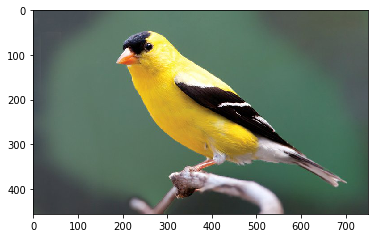

In [56]:
from matplotlib import pyplot as plt
from PIL import Image
img = np.array(Image.open(img_file), dtype=np.float32)
plt.imshow(img.astype(np.uint8))
plt.show()

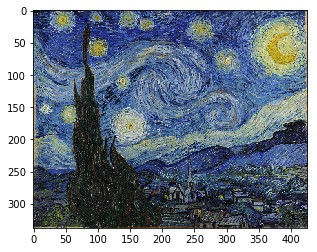

In [57]:
van_img = Image.open(ld.utils.download_file('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'))
van_img = np.array(van_img.resize(np.divide(van_img.size, 3).astype(int)), dtype=np.float32)
plt.imshow(van_img.astype(np.uint8))
plt.show()

In [6]:
%pdb

Automatic pdb calling has been turned ON


In [21]:
from lessdeep.model.vgg16n import Vgg16N
import keras

def create_vgg_avg(image_size=None):
    vgg_avg=Vgg16N(include_top=False, image_size=image_size)
    vgg_avg_layers = []
    for l in vgg_avg.model.layers:
        if isinstance(l, keras.layers.MaxPool2D):
            vgg_avg_layers.append(keras.layers.AveragePooling2D((2, 2), strides=(2, 2)))
        else:
            vgg_avg_layers.append(l)
    vgg_avg.model = ld.utils.clone_model(vgg_avg_layers)
    vgg_avg.compile()
    
    return vgg_avg
vgg_avg = create_vgg_avg()
vgg_avg.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
average_pooling2d_13 (Averag (None, None, None, 64)    0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 128)   147584    
_________________________________________________________________
average_pooling2d_14 (Averag (None, None, None, 128)   0         
__________

In [8]:
conv_idx = [i for i, l in enumerate(vgg_avg.model.layers) if isinstance(l, keras.layers.Conv2D)]

In [9]:
conv_idx

[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]

In [58]:
from keras.applications.imagenet_utils import preprocess_input
img_input = preprocess_input(img.copy())[None]
van_img_input = preprocess_input(van_img.copy())[None]

In [33]:
import keras.backend as K
def reverse_input(x):
    x = x.copy()
    data_format = K.image_data_format()
    if data_format == 'channels_first':
        if x.ndim == 3:
            # 'BGR'->'RGB'
            x = x[::-1, ...]
            # Zero-center by mean pixel
            x[0, :, :] += 123.68
            x[1, :, :] += 116.779
            x[2, :, :] += 103.939
        else:
            x = x[:, ::-1, ...]
            x[:, 0, :, :] += 123.68
            x[:, 1, :, :] += 116.779
            x[:, 2, :, :] += 103.939
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]
        # Zero-center by mean pixel
        x[..., 0] += 123.68
        x[..., 1] += 116.779
        x[..., 2] += 103.939
    return x

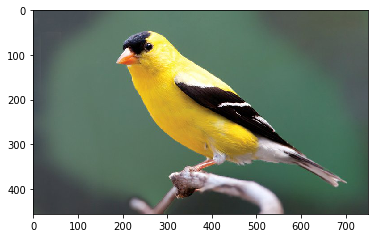

In [59]:
plt.imshow(reverse_input(img_input[0]).astype(np.uint8))
plt.show()

In [39]:
layer = vgg_avg.model.layers[conv_idx[-6]].output
layer_model = keras.Model(vgg_avg.model.input, layer)

In [40]:
tgt = K.variable(layer_model.predict(img_input))

In [41]:
loss = K.mean(keras.metrics.mse(tgt, layer))
grad = K.gradients(loss, vgg_avg.model.input)

In [42]:
class Runner(object):
    def __init__(self, f, in_shape):
        self._f, self.shape = f, in_shape
    def loss(self, x):
        loss, self._grad = self._f([x.reshape(self.shape)])
        return loss.astype(np.float64)
    def grad(self, x):
        return self._grad.astype(np.float64).flatten()
runner = Runner(K.function([vgg_avg.model.input], [loss]+grad), img_input.shape)

In [43]:
from scipy.optimize import fmin_l_bfgs_b

def learn_image(run_obj, x, niter):
    his = []
    for i in range(niter):
        x, f, d = fmin_l_bfgs_b(run_obj.loss, x.flatten(), fprime=run_obj.grad, maxiter=20)
        his.append(x.reshape(run_obj.shape).copy())
        print('Iter {0}: loss {1}'.format(i, f))
    return his

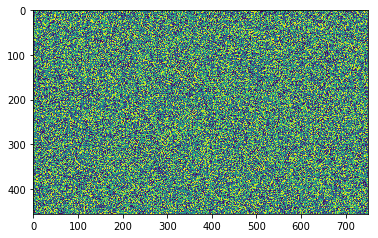

In [44]:
rand_img = np.array(np.random.uniform(-2.5, 2.5, img_input.shape).astype(np.float32)/100)
#rand_img[0]
import matplotlib
plt.imshow(rand_img[0][:,:,0])
plt.show()

In [45]:
his = learn_image(runner, rand_img, niter=20)

Iter 0: loss 2416.750732421875
Iter 1: loss 1229.813232421875
Iter 2: loss 887.3173217773438
Iter 3: loss 727.7074584960938
Iter 4: loss 623.52001953125
Iter 5: loss 545.93310546875
Iter 6: loss 486.87841796875
Iter 7: loss 443.5843811035156
Iter 8: loss 405.03448486328125
Iter 9: loss 371.9906921386719
Iter 10: loss 341.14306640625
Iter 11: loss 314.29400634765625
Iter 12: loss 289.2628173828125
Iter 13: loss 268.7607421875
Iter 14: loss 250.22897338867188
Iter 15: loss 231.29747009277344
Iter 16: loss 214.02134704589844
Iter 17: loss 196.43643188476562
Iter 18: loss 179.8269500732422
Iter 19: loss 164.76495361328125


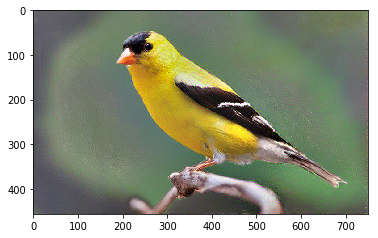

In [100]:
plt.imshow(reverse_input(his[-2][0]).clip(0, 255).astype(np.uint8))

In [ ]:
from IPython.display import HTML
from matplotlib import animation, rc

In [ ]:
#fig, ax = plt.subplots()
def animate(i):
    ax.imshow(reverse_input(his[-1][0]).astype(np.uint8))
#anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
#HTML(anim.to_html5_video())

## Creating Style

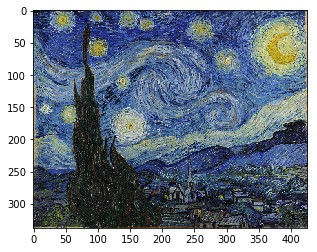

In [92]:
import scipy
plt.imshow(reverse_input(van_img_input[0]).astype(np.uint8))
plt.show()

In [64]:
style_vgg = create_vgg_avg(image_size=van_img_input[0].shape[:2])
style_layers = [style_vgg.model.layers[conv_idx[i]].output for i in range(1, len(conv_idx), 3)]
style_model = keras.Model(style_vgg.model.input, style_layers)
style_tgts = [K.variable(v) for v in style_model.predict(van_img_input)]

In [65]:
def gram_matrix(x):
    tmp = K.permute_dimensions(x, (2, 0, 1))  # convert to (depth, y, x)
    features = K.batch_flatten(tmp)  # keep depth, flatten each feature into one row
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [66]:
def style_loss(x, tgt):
    return K.mean(keras.metrics.mse(gram_matrix(x), gram_matrix(tgt)))

In [67]:
x=style_layers[0][0]
tmp = K.permute_dimensions(x, (2, 0, 1))  # convert to (depth, y, x)
tmp
features = K.batch_flatten(tmp)  # keep depth, flatten each feature into one row
tmp, features, x.get_shape()
#K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

(<tf.Tensor 'transpose:0' shape=(64, 338, 426) dtype=float32>,
 <tf.Tensor 'Reshape:0' shape=(?, ?) dtype=float32>,
 TensorShape([Dimension(338), Dimension(426), Dimension(64)]))

In [80]:
loss = sum([style_loss(l[0], t[0]) for l, t in zip(style_layers, style_tgts)])
grad = K.gradients(loss, [style_vgg.model.input])
style_runner = Runner(K.function([style_vgg.model.input], [loss]+grad), van_img_input.shape)

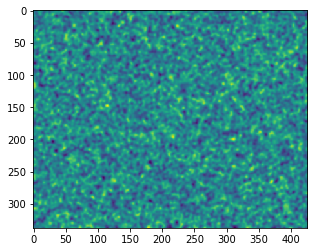

In [94]:
rand_style_img = np.array(np.random.uniform(-2.5, 2.5, van_img_input.shape).astype(np.float32)/100)
rand_style_img = scipy.ndimage.gaussian_filter(rand_style_img, [0, 2, 2, 0])
import matplotlib
plt.imshow(rand_style_img[0][:,:,0])
plt.show()

In [95]:
style_his = learn_image(style_runner, rand_style_img, 10)

Iter 0: loss 2677.533935546875
Iter 1: loss 1039.9439697265625
Iter 2: loss 525.3238525390625
Iter 3: loss 227.7183074951172
Iter 4: loss 114.45791625976562
Iter 5: loss 69.3043212890625
Iter 6: loss 48.25321960449219
Iter 7: loss 34.36735916137695
Iter 8: loss 24.05787467956543
Iter 9: loss 18.66541290283203


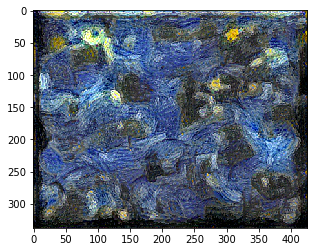

In [101]:
plt.imshow(reverse_input(style_his[-1][0]).clip(0, 255).astype(np.uint8))